
#### Основы нейронных сетей


#### Многослойная сеть на PyTorch

В этом ноутбке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать многослойную полносвязную сеть (Fully-Connected, FC), и сравним их качество на датасете картинок MNIST.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Многослойная нейронная сеть</b></h3>

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Каждый слой состоит из **нейронов**. Ранее мы уже писали свой нейрон на NumPy, вот из таких нейронов и состоит ***MLP (Multi-Layer Perceptron)***. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть у нейронов со слоя $L_{i-1}$  и нейронов $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** на **выходном слое** обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на **выходном слое** обычно один нейрон, если задача бинарной классификации, и $K$ нейронов, если задача $K$-класовой классификации.

#### Forward pass в MLP

Каждый слой многослойной нейросети - это матрица весов, строки которой - это нейроны (одна строка - один нейрон), а столбцы - веса каждого нейрона (то есть одна строка - это веса одного нейрона).

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix} 
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM} 
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1} 
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, у второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2} 
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix} 
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK} 
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге ***для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации***.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации).

**Backward pass в MLP**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

## Датасет
Мы будем работать с датасетом "Игрушка дьявола". Генерация и отрисовка датасета:

In [17]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

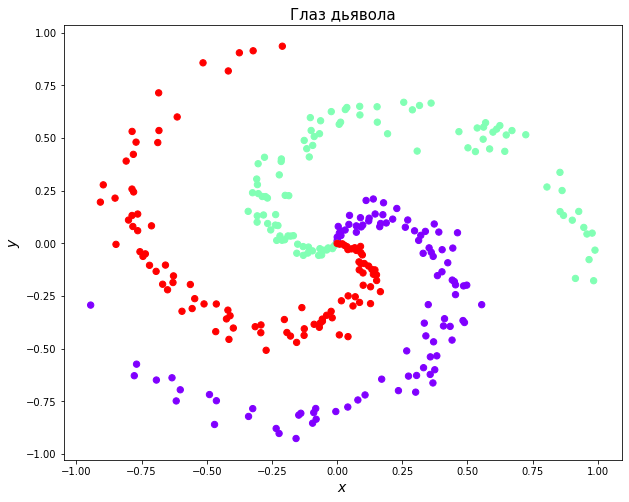

In [18]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Глаз дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

<h3 style="text-align: center;"><b>Многослойная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

## PyTorch для нейронных сетей

Основная абстракция для построения нейронной сети --- это torch.nn.Module. Module --- это те кирпичики, из которых мы будем складывать любую нейронную сеть. Как мы узнали на лекции, для определения модуля достаточно задать методы Forward и Backward. Базовый класс для nn.Module в PyTorch:



In [4]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    :ivar training: Boolean represents whether this module is in training or
                    evaluation mode.
    :vartype training: bool
    


### Модуль Sequential

Основной класс в PyTorch для работы с нейронными сетями --- это  Sequential.  Sequential --- это шаблон для самой простой последовательной нейронной сети. Методы Forward и Backward заданы соответственно: мы пробрасываем выходы и градиенты через все слои, из которых состоит Module. Посмотрим, как это работает.

Не будем медлить - бахнем 100 нейронов в двуслойную нейросеть. 

In [19]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 64, 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Посмотрим, что у нас получилось. Пропустим мусорные данные через нашу модель методом forward.

In [20]:
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

Weight shapes: [torch.Size([100, 2]), torch.Size([100]), torch.Size([3, 100]), torch.Size([3])]


In [21]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

tensor([0.3408, 0.2851, 0.3741], grad_fn=<SelectBackward>)

## Код для генерации мини-батчей



In [22]:
from torch.autograd import Variable

In [23]:
def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [24]:
batch_gen(X, y)[1].shape

torch.Size([128])

In [25]:
two_layer_net.forward(batch_gen(X,y)[0])

tensor([[0.3384, 0.2880, 0.3736],
        [0.3236, 0.3083, 0.3681],
        [0.3478, 0.2770, 0.3752],
        [0.3236, 0.3083, 0.3681],
        [0.3216, 0.2980, 0.3803],
        [0.2983, 0.3327, 0.3691],
        [0.3370, 0.2900, 0.3730],
        [0.3419, 0.2828, 0.3754],
        [0.3427, 0.2807, 0.3766],
        [0.3121, 0.3471, 0.3409],
        [0.3258, 0.2928, 0.3814],
        [0.3412, 0.2552, 0.4036],
        [0.3229, 0.3000, 0.3771],
        [0.3103, 0.3481, 0.3416],
        [0.3232, 0.3065, 0.3702],
        [0.3393, 0.2898, 0.3710],
        [0.3434, 0.2794, 0.3772],
        [0.3457, 0.2753, 0.3790],
        [0.3419, 0.2828, 0.3754],
        [0.3494, 0.2615, 0.3891],
        [0.3212, 0.3337, 0.3452],
        [0.3495, 0.2616, 0.3889],
        [0.3473, 0.2775, 0.3752],
        [0.3456, 0.2724, 0.3820],
        [0.3512, 0.2594, 0.3895],
        [0.3534, 0.2619, 0.3847],
        [0.3388, 0.2885, 0.3727],
        [0.3219, 0.3197, 0.3584],
        [0.3405, 0.2871, 0.3725],
        [0.324

Не забываем оборачивать данные (без этого градиенты не посчитать):

## Функция потерь и оптимизатор

In [26]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

## Обучение модели

In [27]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 140.33982849121094
1 140.64132690429688
2 140.78591918945312
3 140.04054260253906
4 140.70814514160156
5 140.27407836914062
6 140.3155517578125
7 139.92449951171875
8 139.8762664794922
9 140.1615447998047
10 139.9465789794922
11 139.4221954345703
12 139.454833984375
13 139.43753051757812
14 139.4040985107422
15 139.7012176513672
16 139.62733459472656
17 139.1686553955078
18 139.71524047851562
19 139.593994140625
20 139.34542846679688
21 139.51544189453125
22 139.36167907714844
23 139.6483917236328
24 139.23187255859375
25 139.54583740234375
26 140.06158447265625
27 138.8266143798828
28 139.31724548339844
29 139.67306518554688
30 138.8488006591797
31 139.3697052001953
32 139.69888305664062
33 139.5117950439453
34 139.2510528564453
35 139.90245056152344
36 138.49896240234375
37 139.4884490966797
38 138.59765625
39 139.13320922851562
40 138.82382202148438
41 139.1246337890625
42 138.5771942138672
43 139.093994140625
44 138.59878540039062
45 139.56297302246094
46 138.82427978515625
47 13

371 130.47991943359375
372 132.16058349609375
373 129.58917236328125
374 131.7088623046875
375 131.5913848876953
376 132.8759765625
377 130.1992950439453
378 129.95790100097656
379 130.8647918701172
380 131.3419647216797
381 129.46617126464844
382 129.21694946289062
383 131.00926208496094
384 129.6974334716797
385 130.83883666992188
386 130.9676055908203
387 131.2581024169922
388 131.12899780273438
389 131.83013916015625
390 129.7569122314453
391 129.29251098632812
392 130.37193298339844
393 129.73272705078125
394 127.9989013671875
395 129.154541015625
396 128.2849884033203
397 128.81553649902344
398 130.45843505859375
399 130.57896423339844
400 133.27833557128906
401 131.71559143066406
402 128.77529907226562
403 131.02212524414062
404 128.56094360351562
405 129.33843994140625
406 131.81520080566406
407 130.007568359375
408 131.4225616455078
409 129.7738800048828
410 130.2427978515625
411 127.93126678466797
412 127.71791076660156
413 129.8058624267578
414 129.13294982910156
415 126.984

769 125.07154846191406
770 122.2043685913086
771 126.35395812988281
772 127.70376586914062
773 124.42268371582031
774 120.52086639404297
775 122.47982788085938
776 124.62065124511719
777 121.47262573242188
778 124.35567474365234
779 123.72742462158203
780 125.50354766845703
781 125.67823028564453
782 126.6888427734375
783 125.05152130126953
784 125.17985534667969
785 128.30792236328125
786 123.07804870605469
787 121.0851058959961
788 120.83399963378906
789 123.69939422607422
790 122.54701232910156
791 125.43627166748047
792 118.5986557006836
793 124.30353546142578
794 127.13361358642578
795 121.29330444335938
796 125.29298400878906
797 123.59781646728516
798 122.26447296142578
799 125.64642333984375
800 123.8302001953125
801 120.91975402832031
802 123.63876342773438
803 127.89566802978516
804 125.10652160644531
805 122.5826187133789
806 122.16217803955078
807 126.49679565429688
808 128.41725158691406
809 122.35946655273438
810 124.99156188964844
811 125.64229583740234
812 127.045104980

1132 121.98064422607422
1133 119.4314956665039
1134 121.12689971923828
1135 122.3637466430664
1136 124.35103607177734
1137 124.59020233154297
1138 120.76899719238281
1139 116.23457336425781
1140 119.89338684082031
1141 119.3096694946289
1142 119.69347381591797
1143 121.38090515136719
1144 122.12772369384766
1145 116.37928771972656
1146 125.27388763427734
1147 122.33456420898438
1148 123.56439208984375
1149 119.07451629638672
1150 121.8003921508789
1151 121.07875061035156
1152 121.28477478027344
1153 122.46125793457031
1154 121.81802368164062
1155 116.93350219726562
1156 123.51461791992188
1157 120.28911590576172
1158 121.54347229003906
1159 115.67948150634766
1160 119.1075439453125
1161 124.98157501220703
1162 118.05482482910156
1163 122.80303192138672
1164 120.79114532470703
1165 124.11019897460938
1166 121.32843017578125
1167 123.48758697509766
1168 122.38800811767578
1169 120.63301086425781
1170 122.27228546142578
1171 120.24526977539062
1172 122.48155975341797
1173 119.447891235351

1497 112.62164306640625
1498 117.9533920288086
1499 115.6439208984375
1500 116.2406997680664
1501 120.06736755371094
1502 120.03776550292969
1503 117.69679260253906
1504 117.96475982666016
1505 116.24785614013672
1506 118.16229248046875
1507 118.55484008789062
1508 122.18797302246094
1509 117.83711242675781
1510 119.1076889038086
1511 115.61199951171875
1512 117.89022827148438
1513 121.44462585449219
1514 121.43006896972656
1515 115.89306640625
1516 119.57769012451172
1517 122.3602523803711
1518 121.40230560302734
1519 118.44646453857422
1520 119.89463806152344
1521 118.201416015625
1522 123.18675231933594
1523 122.0076675415039
1524 119.6243896484375
1525 116.9284896850586
1526 120.81932830810547
1527 114.8080062866211
1528 119.89889526367188
1529 118.03166961669922
1530 119.38794708251953
1531 116.22794342041016
1532 122.21961212158203
1533 122.03285217285156
1534 123.99519348144531
1535 123.41410827636719
1536 117.60122680664062
1537 117.60150909423828
1538 122.0446548461914
1539 11

1857 115.59529876708984
1858 121.16118621826172
1859 120.26383972167969
1860 117.01509857177734
1861 116.87152099609375
1862 117.46369934082031
1863 119.53512573242188
1864 117.49333953857422
1865 115.9931640625
1866 115.01554870605469
1867 120.49118041992188
1868 116.68597412109375
1869 121.91963195800781
1870 121.41297149658203
1871 113.79914855957031
1872 114.6958236694336
1873 121.6250228881836
1874 115.22289276123047
1875 117.9666748046875
1876 118.9248046875
1877 115.12395477294922
1878 117.79998016357422
1879 120.19416046142578
1880 117.418701171875
1881 117.98001861572266
1882 117.63732147216797
1883 117.06222534179688
1884 121.1751937866211
1885 118.94609069824219
1886 118.83142852783203
1887 116.55406951904297
1888 114.20659637451172
1889 117.04631805419922
1890 116.30775451660156
1891 118.6422348022461
1892 119.3101806640625
1893 118.8109130859375
1894 118.02873229980469
1895 123.666748046875
1896 121.75953674316406
1897 116.60206604003906
1898 115.09194946289062
1899 113.56

2210 114.54855346679688
2211 116.63302612304688
2212 118.05921173095703
2213 117.7447738647461
2214 114.7663345336914
2215 116.43682098388672
2216 116.42691802978516
2217 119.00102996826172
2218 119.25455474853516
2219 117.75149536132812
2220 116.28038787841797
2221 116.46138000488281
2222 118.89189147949219
2223 115.98531341552734
2224 114.61544799804688
2225 119.1324691772461
2226 120.9725112915039
2227 113.75304412841797
2228 121.2936782836914
2229 120.89491271972656
2230 116.15658569335938
2231 118.369384765625
2232 118.12317657470703
2233 120.98749542236328
2234 113.34342956542969
2235 115.22660827636719
2236 113.73322296142578
2237 117.34522247314453
2238 116.4060287475586
2239 120.52710723876953
2240 114.18998718261719
2241 119.53470611572266
2242 119.63615417480469
2243 116.28263854980469
2244 120.74042510986328
2245 115.56427764892578
2246 109.79924774169922
2247 118.35233306884766
2248 118.22596740722656
2249 117.54472351074219
2250 117.89918518066406
2251 116.29789733886719


2564 115.79570770263672
2565 116.05140686035156
2566 115.96031951904297
2567 111.8951416015625
2568 117.92048645019531
2569 113.02474212646484
2570 116.28402709960938
2571 115.57640838623047
2572 114.39282989501953
2573 110.24615478515625
2574 114.27507781982422
2575 119.49444580078125
2576 117.27510833740234
2577 116.16064453125
2578 117.59468841552734
2579 115.39633178710938
2580 116.62132263183594
2581 113.25495910644531
2582 112.85791778564453
2583 117.33595275878906
2584 118.02586364746094
2585 113.83920288085938
2586 114.88416290283203
2587 114.79094696044922
2588 113.03514862060547
2589 113.5047607421875
2590 112.97370910644531
2591 117.99304962158203
2592 117.56829071044922
2593 115.63440704345703
2594 118.0891342163086
2595 116.97708892822266
2596 114.96405029296875
2597 115.24967193603516
2598 113.57951354980469
2599 117.49048614501953
2600 113.39533996582031
2601 116.53734588623047
2602 117.4170150756836
2603 114.75736999511719
2604 114.50973510742188
2605 122.26663970947266

2923 117.55769348144531
2924 112.11397552490234
2925 114.95590209960938
2926 118.13138580322266
2927 117.81582641601562
2928 116.47455596923828
2929 113.3227310180664
2930 119.60285949707031
2931 116.8486099243164
2932 118.59378814697266
2933 113.42279815673828
2934 114.68444061279297
2935 121.73969268798828
2936 117.82079315185547
2937 115.76838684082031
2938 116.96597290039062
2939 114.93189239501953
2940 113.07828521728516
2941 114.37787628173828
2942 114.01402282714844
2943 118.47693634033203
2944 114.45670318603516
2945 116.58389282226562
2946 113.87693786621094
2947 118.10945129394531
2948 115.8786849975586
2949 111.9832763671875
2950 113.16488647460938
2951 118.73003387451172
2952 113.1607666015625
2953 118.06854248046875
2954 114.9873275756836
2955 110.7021255493164
2956 118.92835235595703
2957 116.9789047241211
2958 115.32894897460938
2959 113.67669677734375
2960 116.6266860961914
2961 118.75621795654297
2962 116.2383804321289
2963 118.83907318115234
2964 110.82140350341797
29

3287 111.77022552490234
3288 116.6850357055664
3289 116.33482360839844
3290 112.53971862792969
3291 113.8889389038086
3292 115.48221588134766
3293 112.63496398925781
3294 110.23197937011719
3295 113.6308364868164
3296 118.57078552246094
3297 113.5245361328125
3298 120.80036163330078
3299 114.7718276977539
3300 113.82090759277344
3301 116.59793090820312
3302 114.38483428955078
3303 116.13926696777344
3304 115.32322692871094
3305 114.15975189208984
3306 114.74819946289062
3307 117.37625122070312
3308 116.55281829833984
3309 119.74540710449219
3310 115.50448608398438
3311 110.92719268798828
3312 119.09829711914062
3313 114.73773193359375
3314 115.73538970947266
3315 117.61798858642578
3316 110.88872528076172
3317 114.72117614746094
3318 115.30950164794922
3319 119.61412811279297
3320 115.99662017822266
3321 113.80445098876953
3322 117.1732177734375
3323 111.61382293701172
3324 120.57465362548828
3325 114.4080810546875
3326 116.08876037597656
3327 112.14030456542969
3328 113.43814849853516

3665 112.99386596679688
3666 109.94536590576172
3667 113.6600570678711
3668 114.33969116210938
3669 111.01329803466797
3670 115.82955932617188
3671 111.84175109863281
3672 114.04957580566406
3673 117.9336929321289
3674 116.2277603149414
3675 112.86654663085938
3676 115.0626220703125
3677 109.09464263916016
3678 113.90682220458984
3679 112.37361907958984
3680 114.6829833984375
3681 114.24881744384766
3682 118.28929901123047
3683 116.10150146484375
3684 115.47032928466797
3685 112.44827270507812
3686 113.5557861328125
3687 115.09561157226562
3688 107.36587524414062
3689 120.37138366699219
3690 115.40391540527344
3691 118.4975357055664
3692 113.86449432373047
3693 111.49562072753906
3694 111.07331085205078
3695 114.98361206054688
3696 112.98529815673828
3697 112.54905700683594
3698 113.06159973144531
3699 114.92276000976562
3700 117.65980529785156
3701 110.36660766601562
3702 112.97183990478516
3703 117.516357421875
3704 114.07994079589844
3705 115.43818664550781
3706 113.13316345214844
3

4021 117.34538269042969
4022 115.0373306274414
4023 115.83871459960938
4024 108.9909439086914
4025 112.95770263671875
4026 113.50188446044922
4027 112.21929168701172
4028 119.12689208984375
4029 112.90179443359375
4030 112.94615173339844
4031 111.73960876464844
4032 110.73188781738281
4033 114.15245819091797
4034 115.68362426757812
4035 111.97895050048828
4036 112.67829895019531
4037 114.6621322631836
4038 115.78096008300781
4039 106.14461517333984
4040 112.75399017333984
4041 114.47050476074219
4042 112.53522491455078
4043 119.84599304199219
4044 110.22863006591797
4045 114.63390350341797
4046 117.4333267211914
4047 115.02073669433594
4048 115.02789306640625
4049 113.43792724609375
4050 111.2933578491211
4051 119.74658966064453
4052 115.77826690673828
4053 111.60263061523438
4054 113.66596221923828
4055 116.69078063964844
4056 111.8532943725586
4057 112.83600616455078
4058 114.51051330566406
4059 112.9371566772461
4060 113.62682342529297
4061 117.55316162109375
4062 115.0101547241211


4384 114.38990783691406
4385 114.64012145996094
4386 114.40290832519531
4387 117.58024597167969
4388 115.29952239990234
4389 114.90754699707031
4390 114.38793182373047
4391 113.57323455810547
4392 114.35565948486328
4393 113.49066162109375
4394 115.6441421508789
4395 115.6982421875
4396 116.4665298461914
4397 115.20265197753906
4398 116.84519958496094
4399 113.5505599975586
4400 110.88847351074219
4401 115.99166870117188
4402 111.5419921875
4403 113.4156723022461
4404 112.9970932006836
4405 116.21382141113281
4406 117.67711639404297
4407 118.2361068725586
4408 115.3880615234375
4409 115.62943267822266
4410 115.54398345947266
4411 117.94883728027344
4412 112.3847885131836
4413 109.72069549560547
4414 114.25411987304688
4415 115.19896697998047
4416 116.77689361572266
4417 115.70821380615234
4418 113.00636291503906
4419 113.7703857421875
4420 112.59359741210938
4421 112.93061065673828
4422 116.13980102539062
4423 111.36257934570312
4424 118.41254425048828
4425 114.62882995605469
4426 113.

4767 113.60768127441406
4768 111.46731567382812
4769 115.25811767578125
4770 107.74893188476562
4771 109.98934936523438
4772 113.58168029785156
4773 114.59613037109375
4774 113.4094009399414
4775 117.13804626464844
4776 115.91243743896484
4777 111.0999755859375
4778 113.78653717041016
4779 116.0708236694336
4780 112.67941284179688
4781 114.73017883300781
4782 116.39230346679688
4783 114.26966094970703
4784 115.92619323730469
4785 115.4229965209961
4786 116.14750671386719
4787 117.64901733398438
4788 118.62934875488281
4789 106.33895111083984
4790 116.53988647460938
4791 112.91542053222656
4792 111.83414459228516
4793 109.94463348388672
4794 113.54663848876953
4795 109.41703796386719
4796 119.1640625
4797 110.75385284423828
4798 118.63997650146484
4799 114.47850036621094
4800 118.67353820800781
4801 117.09056854248047
4802 115.53313446044922
4803 113.98966979980469
4804 107.6181869506836
4805 107.3170394897461
4806 111.47360229492188
4807 111.67627716064453
4808 111.49851989746094
4809 

5120 116.03721618652344
5121 110.05241394042969
5122 109.51351165771484
5123 110.94396209716797
5124 115.01622772216797
5125 112.73953247070312
5126 114.17145538330078
5127 113.54808044433594
5128 109.66798400878906
5129 115.72373962402344
5130 111.43590545654297
5131 114.3697738647461
5132 110.86671447753906
5133 111.98368835449219
5134 110.12533569335938
5135 115.71258544921875
5136 111.18991088867188
5137 109.47825622558594
5138 111.7975845336914
5139 112.90074920654297
5140 112.16844940185547
5141 109.8175277709961
5142 114.45564270019531
5143 113.10807037353516
5144 118.242431640625
5145 117.06908416748047
5146 119.5018310546875
5147 112.02571868896484
5148 114.74971008300781
5149 110.05449676513672
5150 116.33528900146484
5151 112.04051971435547
5152 108.58269500732422
5153 116.61627197265625
5154 111.611328125
5155 110.68062591552734
5156 109.66947937011719
5157 115.70095825195312
5158 114.27178955078125
5159 110.67179870605469
5160 110.69788360595703
5161 115.49615478515625
516

5467 111.79507446289062
5468 108.56826782226562
5469 116.24789428710938
5470 111.85675811767578
5471 115.04857635498047
5472 114.70967102050781
5473 110.21780395507812
5474 109.75357818603516
5475 111.7454605102539
5476 107.522216796875
5477 109.60182189941406
5478 113.56299591064453
5479 118.24419403076172
5480 116.4815673828125
5481 111.07762145996094
5482 109.98486328125
5483 110.00895690917969
5484 114.12808990478516
5485 109.46292114257812
5486 109.80097961425781
5487 114.19253540039062
5488 113.1072769165039
5489 112.03579711914062
5490 111.2044448852539
5491 109.72772979736328
5492 114.61306762695312
5493 113.04339599609375
5494 108.28407287597656
5495 106.79026794433594
5496 112.27918243408203
5497 117.15638732910156
5498 109.2333755493164
5499 108.87879943847656
5500 109.12308502197266
5501 112.43974304199219
5502 112.29969024658203
5503 114.45463562011719
5504 107.16613006591797
5505 113.61365509033203
5506 111.19062805175781
5507 116.19354248046875
5508 108.40251159667969
55

5842 109.45096588134766
5843 113.05778503417969
5844 114.8816909790039
5845 112.75535583496094
5846 110.78189086914062
5847 113.29064178466797
5848 108.4586410522461
5849 112.29002380371094
5850 109.25059509277344
5851 114.27304077148438
5852 114.60279083251953
5853 109.8433609008789
5854 110.6913833618164
5855 108.4334716796875
5856 114.88798522949219
5857 111.57380676269531
5858 113.93572998046875
5859 110.60491943359375
5860 110.81708526611328
5861 112.9035415649414
5862 109.27436065673828
5863 110.6322021484375
5864 110.47423553466797
5865 105.2374038696289
5866 112.59927368164062
5867 113.70885467529297
5868 114.6407241821289
5869 111.05907440185547
5870 111.54359436035156
5871 114.42316436767578
5872 111.43345642089844
5873 109.0650405883789
5874 110.4463119506836
5875 111.76891326904297
5876 113.28953552246094
5877 112.02874755859375
5878 107.45999908447266
5879 117.44039154052734
5880 106.85456848144531
5881 107.19094848632812
5882 113.29463195800781
5883 106.97281646728516
588

6209 113.78533172607422
6210 111.69879913330078
6211 105.33914947509766
6212 112.24565124511719
6213 115.37501525878906
6214 110.76622009277344
6215 109.33281707763672
6216 110.46349334716797
6217 111.0076904296875
6218 113.39332580566406
6219 114.697021484375
6220 110.87948608398438
6221 109.95559692382812
6222 114.3795394897461
6223 118.65205383300781
6224 114.77374267578125
6225 112.96307373046875
6226 106.94554138183594
6227 112.29711151123047
6228 113.95675659179688
6229 109.60432434082031
6230 110.44451904296875
6231 108.859619140625
6232 108.91768646240234
6233 114.14287567138672
6234 112.19954681396484
6235 111.88712310791016
6236 106.98857879638672
6237 114.58167266845703
6238 114.0542221069336
6239 106.74423217773438
6240 112.34838104248047
6241 107.13545227050781
6242 110.20781707763672
6243 113.77342224121094
6244 109.960693359375
6245 109.65531158447266
6246 116.16062927246094
6247 113.96576690673828
6248 112.7540512084961
6249 109.61570739746094
6250 105.55545806884766
62

6561 113.7953872680664
6562 113.53934478759766
6563 112.28425598144531
6564 109.68626403808594
6565 114.47386932373047
6566 107.51121520996094
6567 109.00132751464844
6568 115.50288391113281
6569 110.29624938964844
6570 113.62025451660156
6571 109.75727081298828
6572 110.29341125488281
6573 109.1312026977539
6574 116.15755462646484
6575 110.4362564086914
6576 116.11286926269531
6577 110.53535461425781
6578 107.12216186523438
6579 112.08558654785156
6580 107.53517150878906
6581 108.99405670166016
6582 108.0959243774414
6583 112.16446685791016
6584 103.2130126953125
6585 111.34146118164062
6586 114.93379974365234
6587 110.22699737548828
6588 113.5059585571289
6589 110.15204620361328
6590 118.0726318359375
6591 112.64939880371094
6592 113.55297088623047
6593 115.56806945800781
6594 107.63457489013672
6595 111.70032501220703
6596 107.13520812988281
6597 109.36470794677734
6598 110.51559448242188
6599 109.3907241821289
6600 112.18411254882812
6601 111.49191284179688
6602 109.40496063232422


6921 110.40469360351562
6922 107.03189086914062
6923 109.99496459960938
6924 105.7058334350586
6925 108.22320556640625
6926 111.37574768066406
6927 112.91184997558594
6928 111.61761474609375
6929 111.37100982666016
6930 111.7488021850586
6931 109.0003662109375
6932 107.92830657958984
6933 111.56463623046875
6934 112.27388000488281
6935 106.88292694091797
6936 104.12269592285156
6937 108.83094024658203
6938 105.43699645996094
6939 111.88623046875
6940 109.64861297607422
6941 108.03063201904297
6942 108.73294830322266
6943 108.42959594726562
6944 111.55509185791016
6945 107.71087646484375
6946 116.25843811035156
6947 107.9967041015625
6948 106.14140319824219
6949 114.00780487060547
6950 107.22673797607422
6951 110.17205810546875
6952 107.54769897460938
6953 106.6627197265625
6954 108.15628051757812
6955 112.07905578613281
6956 110.1803970336914
6957 110.99403381347656
6958 108.35892486572266
6959 106.43692016601562
6960 111.2311782836914
6961 106.43168640136719
6962 108.67109680175781
69

7303 106.21022033691406
7304 111.01396179199219
7305 110.3052749633789
7306 107.33673095703125
7307 112.16964721679688
7308 109.45276641845703
7309 108.13300323486328
7310 106.44442749023438
7311 110.08682250976562
7312 107.91175842285156
7313 105.29681396484375
7314 113.51725006103516
7315 109.6049575805664
7316 110.1176986694336
7317 110.55091857910156
7318 106.99376678466797
7319 104.24832916259766
7320 108.01517486572266
7321 116.13455200195312
7322 114.2016830444336
7323 111.55640411376953
7324 114.87796020507812
7325 113.52208709716797
7326 108.68930053710938
7327 107.79164123535156
7328 112.56464385986328
7329 105.88551330566406
7330 105.09602355957031
7331 106.08757781982422
7332 106.27872467041016
7333 105.91600799560547
7334 108.78346252441406
7335 113.8011245727539
7336 106.9149169921875
7337 109.5990982055664
7338 106.43704986572266
7339 109.1950454711914
7340 112.29389190673828
7341 107.88177490234375
7342 110.9324951171875
7343 106.48780059814453
7344 106.25142669677734
7

7652 107.47323608398438
7653 115.3525619506836
7654 108.20438385009766
7655 107.94805145263672
7656 113.76864624023438
7657 108.71112060546875
7658 110.33789825439453
7659 109.79911041259766
7660 110.8824462890625
7661 112.0419921875
7662 108.84085845947266
7663 107.56319427490234
7664 107.66419219970703
7665 111.85687255859375
7666 114.45929718017578
7667 107.34940338134766
7668 108.91009521484375
7669 106.76985168457031
7670 109.32167053222656
7671 107.89458465576172
7672 112.32337951660156
7673 114.94387817382812
7674 111.906494140625
7675 102.77730560302734
7676 112.83939361572266
7677 107.89657592773438
7678 108.90806579589844
7679 113.86780548095703
7680 106.05116271972656
7681 109.362548828125
7682 106.36942291259766
7683 112.9605712890625
7684 107.0988540649414
7685 106.46623229980469
7686 105.96061706542969
7687 106.23657989501953
7688 111.8637924194336
7689 114.30045318603516
7690 106.39689636230469
7691 118.32054901123047
7692 113.00601196289062
7693 103.92936706542969
7694 

8018 106.74909210205078
8019 110.6436538696289
8020 107.11984252929688
8021 103.49319458007812
8022 105.10002899169922
8023 105.06753540039062
8024 102.21634674072266
8025 107.62571716308594
8026 106.22832489013672
8027 106.4413833618164
8028 107.5890121459961
8029 112.07223510742188
8030 107.93277740478516
8031 107.62718200683594
8032 107.11078643798828
8033 104.45274353027344
8034 109.00984191894531
8035 102.39009857177734
8036 105.11021423339844
8037 107.75521850585938
8038 110.01992797851562
8039 113.99120330810547
8040 103.85445404052734
8041 110.93665313720703
8042 108.95379638671875
8043 107.96105194091797
8044 108.21822357177734
8045 112.62065887451172
8046 110.55746459960938
8047 112.08128356933594
8048 110.57683563232422
8049 110.65653228759766
8050 106.81482696533203
8051 107.69213104248047
8052 106.65990447998047
8053 109.7690200805664
8054 105.48919677734375
8055 104.6266860961914
8056 110.1123046875
8057 104.98371124267578
8058 111.91619873046875
8059 112.5313491821289
80

8390 112.70051574707031
8391 108.36605072021484
8392 110.97315979003906
8393 108.7878646850586
8394 110.37806701660156
8395 102.06727600097656
8396 108.09506225585938
8397 106.30513000488281
8398 108.79205322265625
8399 107.99729919433594
8400 103.97334289550781
8401 108.2937240600586
8402 106.83141326904297
8403 104.96407318115234
8404 109.7068862915039
8405 109.91258239746094
8406 109.15142059326172
8407 109.81109619140625
8408 105.60051727294922
8409 108.12032318115234
8410 105.64855194091797
8411 109.09184265136719
8412 107.48724365234375
8413 110.03687286376953
8414 108.27946472167969
8415 112.38815307617188
8416 105.85468292236328
8417 109.73065948486328
8418 114.57547760009766
8419 106.87907409667969
8420 107.34032440185547
8421 103.4981689453125
8422 107.6815185546875
8423 107.82415008544922
8424 106.47309875488281
8425 114.36424255371094
8426 107.434814453125
8427 110.36134338378906
8428 112.01998138427734
8429 107.22355651855469
8430 105.46920776367188
8431 105.43675231933594

8766 110.26776885986328
8767 107.93347930908203
8768 112.309326171875
8769 109.20049285888672
8770 113.30985260009766
8771 108.12213897705078
8772 103.47152709960938
8773 106.87422180175781
8774 104.22914123535156
8775 106.02709197998047
8776 106.42866516113281
8777 110.6463851928711
8778 112.18004608154297
8779 109.4374008178711
8780 107.36571502685547
8781 107.96035766601562
8782 104.72053527832031
8783 107.66796875
8784 111.7557373046875
8785 109.94044494628906
8786 106.32820129394531
8787 109.18902587890625
8788 106.55375671386719
8789 108.16995239257812
8790 109.77079010009766
8791 111.8095703125
8792 109.23027038574219
8793 104.2018814086914
8794 108.75237274169922
8795 105.70738983154297
8796 106.50593566894531
8797 106.49283599853516
8798 108.5420913696289
8799 105.34186553955078
8800 107.76895141601562
8801 107.61988830566406
8802 105.27999114990234
8803 106.82503509521484
8804 108.59896087646484
8805 105.84274291992188
8806 106.90763854980469
8807 109.70333862304688
8808 104.

9138 110.60962677001953
9139 107.61463165283203
9140 103.85769653320312
9141 108.87417602539062
9142 102.42140197753906
9143 106.71537017822266
9144 103.29057312011719
9145 107.31842803955078
9146 107.68926239013672
9147 110.35918426513672
9148 106.78217315673828
9149 107.75390625
9150 109.62626647949219
9151 104.1658935546875
9152 112.73635864257812
9153 103.65824127197266
9154 106.99325561523438
9155 106.23344421386719
9156 107.3027114868164
9157 108.2687759399414
9158 110.27072143554688
9159 106.339111328125
9160 106.17097473144531
9161 105.85028839111328
9162 107.3424072265625
9163 104.58882141113281
9164 109.37034606933594
9165 109.9320068359375
9166 102.30726623535156
9167 102.5444107055664
9168 109.90857696533203
9169 105.66554260253906
9170 108.7967529296875
9171 109.06600952148438
9172 112.5867919921875
9173 108.40282440185547
9174 107.13035583496094
9175 107.1852035522461
9176 106.60655212402344
9177 108.9991226196289
9178 106.97553253173828
9179 104.98601531982422
9180 108.3

9484 105.065185546875
9485 105.7440414428711
9486 107.17000579833984
9487 105.78527069091797
9488 104.29784393310547
9489 108.00535583496094
9490 103.20269012451172
9491 105.9740219116211
9492 105.91830444335938
9493 105.8647232055664
9494 102.55411529541016
9495 104.85111236572266
9496 109.23957824707031
9497 108.20887756347656
9498 102.87814331054688
9499 107.6273422241211
9500 106.78717803955078
9501 111.21263885498047
9502 108.57276916503906
9503 103.2698745727539
9504 102.71794128417969
9505 105.72406005859375
9506 103.53960418701172
9507 106.66899108886719
9508 110.88668823242188
9509 106.83927917480469
9510 109.8232192993164
9511 107.83821868896484
9512 105.90703582763672
9513 105.84441375732422
9514 104.06900024414062
9515 110.6779556274414
9516 109.98680114746094
9517 106.31985473632812
9518 104.41136932373047
9519 107.90230560302734
9520 103.43498229980469
9521 109.7152328491211
9522 108.17449951171875
9523 108.75460815429688
9524 107.07772064208984
9525 104.89110565185547
95

9846 107.99081420898438
9847 110.7169189453125
9848 104.6198959350586
9849 109.89981079101562
9850 109.3883056640625
9851 106.4559555053711
9852 107.64274597167969
9853 106.37232971191406
9854 104.94108581542969
9855 106.67601013183594
9856 110.72144317626953
9857 109.61837768554688
9858 103.61662292480469
9859 107.47233581542969
9860 107.61724090576172
9861 112.92863464355469
9862 108.71685791015625
9863 107.35980987548828
9864 101.55685424804688
9865 102.94223022460938
9866 109.22714233398438
9867 105.03083038330078
9868 107.92159271240234
9869 109.09416961669922
9870 108.25362396240234
9871 104.79254150390625
9872 112.96360778808594
9873 106.92341613769531
9874 108.42101287841797
9875 104.3238296508789
9876 105.4983139038086
9877 105.79325103759766
9878 109.52010345458984
9879 107.8538818359375
9880 105.73348999023438
9881 102.20482635498047
9882 106.97280883789062
9883 102.1467056274414
9884 104.59516906738281
9885 104.1465072631836
9886 105.44332885742188
9887 105.45816040039062
9

**Обратите внимание:** несмотря на то, что это задача 3-х классовой классификации и столбец $y$ нужно по-хорошему кодировать OneHotEncoding'ом, мы подали просто столбец из 0, 1 и 2 и всё отработало. Вывод - PyTorch сам делает OneHot в таком случае.

Проверим, насколько хороша наша сеть из 100 нейронов:

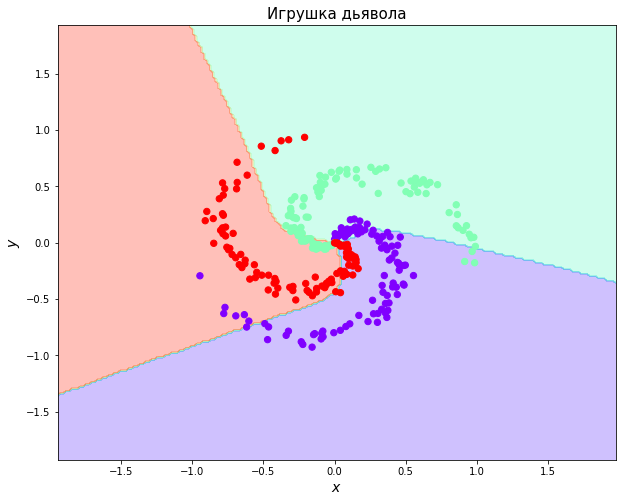

In [28]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Качество не очень. Как же так, ведь мы использовали 100 нейронов? Разве их мало?

---

### Задача 2

Улучшите сеть (помните про вещи, которые можно менять (см. Компоненты нейросети)). Экспериментируйте, в этом **вся суть deep learning** (и в том, чтобы рано или поздно сетка научилась экспериментировать за Вас :)

In [67]:
# Ваш код здесь (можно (и нужно) создавать больше ячеек)
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 32, 2, 200, 3                                # changed H to 120 from 100, N from 64 to 32

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

In [68]:
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

Weight shapes: [torch.Size([200, 2]), torch.Size([200]), torch.Size([3, 200]), torch.Size([3])]


In [69]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

tensor([0.3619, 0.3717, 0.2664], grad_fn=<SelectBackward>)

In [70]:
from torch.autograd import Variable

In [71]:
def batch_gen(X, y, batch_size=128):    # reduced batch size from 128
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [72]:
two_layer_net.forward(batch_gen(X,y)[0])

tensor([[0.3636, 0.3681, 0.2683],
        [0.3452, 0.3953, 0.2594],
        [0.3624, 0.3713, 0.2663],
        [0.3619, 0.3717, 0.2664],
        [0.3644, 0.3771, 0.2585],
        [0.3610, 0.3726, 0.2664],
        [0.3574, 0.3695, 0.2732],
        [0.3638, 0.3666, 0.2695],
        [0.3631, 0.3798, 0.2572],
        [0.3599, 0.3609, 0.2792],
        [0.3632, 0.3697, 0.2671],
        [0.3563, 0.3800, 0.2636],
        [0.3479, 0.3992, 0.2529],
        [0.3619, 0.3778, 0.2603],
        [0.3479, 0.3992, 0.2529],
        [0.3659, 0.3638, 0.2703],
        [0.3489, 0.3868, 0.2643],
        [0.3467, 0.3902, 0.2631],
        [0.3481, 0.3839, 0.2680],
        [0.3552, 0.3777, 0.2671],
        [0.3619, 0.3778, 0.2603],
        [0.3484, 0.3881, 0.2635],
        [0.3367, 0.4223, 0.2410],
        [0.3507, 0.3888, 0.2605],
        [0.3469, 0.3925, 0.2605],
        [0.3566, 0.3605, 0.2829],
        [0.3659, 0.3640, 0.2701],
        [0.3622, 0.3714, 0.2664],
        [0.3468, 0.3927, 0.2605],
        [0.362

In [73]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-1     # changed l.r. from e-3 to e-1
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

In [74]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 141.16876220703125
1 136.67031860351562
2 123.89432525634766
3 125.73455047607422
4 127.10548400878906
5 126.86466979980469
6 124.00180053710938
7 136.66610717773438
8 131.8770294189453
9 116.76414489746094
10 119.4394760131836
11 128.47926330566406
12 119.42438507080078
13 122.47892761230469
14 115.86812591552734
15 118.655029296875
16 118.36186981201172
17 120.05310821533203
18 118.60021209716797
19 122.37452697753906
20 113.01172637939453
21 111.89583587646484
22 112.97684478759766
23 106.64942932128906
24 110.62228393554688
25 142.23179626464844
26 111.78921508789062
27 118.72330474853516
28 125.9860610961914
29 115.68619537353516
30 119.05960845947266
31 111.72509002685547
32 114.90913391113281
33 118.2939224243164
34 112.4442138671875
35 108.31808471679688
36 109.64385223388672
37 128.7764892578125
38 107.61604309082031
39 108.30279541015625
40 102.3272705078125
41 111.54828643798828
42 119.1805191040039
43 118.91975402832031
44 111.6262435913086
45 110.9918212890625
46 120.435

401 74.36341094970703
402 74.79566192626953
403 75.72538757324219
404 74.5620346069336
405 75.81008911132812
406 74.14019775390625
407 73.32210540771484
408 77.41500854492188
409 75.27185821533203
410 77.33084869384766
411 75.9200439453125
412 75.60053253173828
413 74.64826965332031
414 76.09314727783203
415 75.02031707763672
416 75.588623046875
417 76.14484405517578
418 78.35382843017578
419 78.03319549560547
420 80.6315689086914
421 73.65410614013672
422 76.27458190917969
423 76.50247955322266
424 72.04353332519531
425 72.79682159423828
426 74.40938568115234
427 74.68462371826172
428 73.75201416015625
429 74.2731704711914
430 77.08721160888672
431 74.2274169921875
432 72.06494903564453
433 73.208984375
434 76.00849151611328
435 78.99943542480469
436 77.28752136230469
437 75.903564453125
438 77.60411071777344
439 74.1729965209961
440 74.49127197265625
441 73.93819427490234
442 77.31388854980469
443 76.20668029785156
444 73.9688720703125
445 77.0064926147461
446 74.80558013916016
447 7

779 73.66034698486328
780 74.86263275146484
781 73.46232604980469
782 73.33658599853516
783 74.50721740722656
784 73.4104995727539
785 72.93754577636719
786 75.77792358398438
787 75.51708221435547
788 76.40081787109375
789 74.7359619140625
790 71.4994888305664
791 75.43394470214844
792 72.35749053955078
793 72.36640167236328
794 73.59492492675781
795 75.66498565673828
796 71.62561798095703
797 73.42790222167969
798 71.73247528076172
799 72.57735443115234
800 73.00994873046875
801 75.50047302246094
802 72.64598846435547
803 72.16075897216797
804 71.68991088867188
805 75.87460327148438
806 72.36357879638672
807 72.37910461425781
808 72.20184326171875
809 71.46713256835938
810 73.91976165771484
811 77.39698791503906
812 73.92536926269531
813 76.97050476074219
814 75.65093231201172
815 72.07904815673828
816 72.71471405029297
817 73.31580352783203
818 71.02677154541016
819 72.9509048461914
820 71.87490844726562
821 73.77942657470703
822 74.64364624023438
823 75.76207733154297
824 86.2116699

1158 72.74546813964844
1159 74.98587799072266
1160 71.0401382446289
1161 71.99513244628906
1162 71.7420654296875
1163 72.84905242919922
1164 71.85916137695312
1165 71.99263763427734
1166 73.83429718017578
1167 71.47416687011719
1168 71.59358978271484
1169 72.68805694580078
1170 73.15909576416016
1171 71.87532806396484
1172 73.45738983154297
1173 73.2832260131836
1174 72.00125122070312
1175 71.78221893310547
1176 75.10014343261719
1177 75.79800415039062
1178 76.73114776611328
1179 71.18010711669922
1180 73.75678253173828
1181 72.16963958740234
1182 71.84325408935547
1183 72.03771209716797
1184 72.8051528930664
1185 77.27902221679688
1186 72.6117172241211
1187 71.95945739746094
1188 74.17076873779297
1189 73.20357513427734
1190 72.84000396728516
1191 73.10526275634766
1192 71.78643798828125
1193 71.71746063232422
1194 73.0318603515625
1195 72.1078109741211
1196 74.04093170166016
1197 70.99974822998047
1198 72.121337890625
1199 73.62274169921875
1200 71.4809799194336
1201 72.1715545654296

1536 72.72994995117188
1537 74.49026489257812
1538 73.23992156982422
1539 73.11499786376953
1540 75.6697006225586
1541 76.72097778320312
1542 70.59333801269531
1543 70.7903060913086
1544 71.76502990722656
1545 73.4412612915039
1546 72.11796569824219
1547 73.3684310913086
1548 74.70156860351562
1549 73.39269256591797
1550 73.61746978759766
1551 73.49165344238281
1552 75.69700622558594
1553 72.77848052978516
1554 71.81069946289062
1555 70.7125473022461
1556 72.69449615478516
1557 72.14987182617188
1558 72.47863006591797
1559 77.1626205444336
1560 72.81640625
1561 74.4871597290039
1562 73.43013000488281
1563 74.00321197509766
1564 78.19917297363281
1565 74.08662414550781
1566 74.25819396972656
1567 73.31056213378906
1568 72.25393676757812
1569 71.87345886230469
1570 71.32611846923828
1571 71.27951049804688
1572 71.77215576171875
1573 72.8808822631836
1574 73.6628189086914
1575 73.34485626220703
1576 72.94107055664062
1577 75.41584014892578
1578 76.32984161376953
1579 72.12581634521484
158

1919 71.32875061035156
1920 72.38845825195312
1921 74.29985809326172
1922 75.6500015258789
1923 70.87752532958984
1924 71.93074798583984
1925 74.0721206665039
1926 72.59712219238281
1927 74.69590759277344
1928 71.38682556152344
1929 73.85523223876953
1930 74.56106567382812
1931 71.86493682861328
1932 70.8707504272461
1933 72.62629699707031
1934 71.55540466308594
1935 72.5347900390625
1936 71.75273132324219
1937 74.06259155273438
1938 74.1248550415039
1939 76.59881591796875
1940 71.54048156738281
1941 72.42900085449219
1942 76.3558120727539
1943 73.91426849365234
1944 74.56503295898438
1945 72.86848449707031
1946 73.67797088623047
1947 70.67386627197266
1948 72.11565399169922
1949 73.12625122070312
1950 71.50315856933594
1951 70.7671127319336
1952 72.78666687011719
1953 72.2575912475586
1954 72.45379638671875
1955 72.29541015625
1956 76.34187316894531
1957 72.15581512451172
1958 73.86312866210938
1959 73.4839096069336
1960 71.61576080322266
1961 78.1700668334961
1962 71.54928588867188
1

2288 72.42618560791016
2289 72.56034851074219
2290 74.44280242919922
2291 73.27957153320312
2292 73.78863525390625
2293 73.00492858886719
2294 71.69290924072266
2295 72.0697250366211
2296 71.07715606689453
2297 71.81427764892578
2298 73.4561996459961
2299 71.78488159179688
2300 74.19892120361328
2301 77.74909210205078
2302 73.04936218261719
2303 72.66230773925781
2304 73.94680786132812
2305 72.4409408569336
2306 75.02987670898438
2307 72.71057891845703
2308 71.65116882324219
2309 70.71537017822266
2310 70.70630645751953
2311 71.79346466064453
2312 72.8849105834961
2313 72.73436737060547
2314 72.82614135742188
2315 74.9671630859375
2316 74.07333374023438
2317 73.3205337524414
2318 74.06488800048828
2319 72.56016540527344
2320 71.8880386352539
2321 72.64510345458984
2322 76.34208679199219
2323 72.21359252929688
2324 72.57347106933594
2325 72.1346664428711
2326 71.56527709960938
2327 72.06150817871094
2328 72.64505004882812
2329 71.6524887084961
2330 71.71669006347656
2331 70.617103576660

2651 73.3014144897461
2652 74.24698638916016
2653 72.73499298095703
2654 71.24810791015625
2655 70.60713195800781
2656 72.90776062011719
2657 71.72135162353516
2658 72.47282409667969
2659 74.04864501953125
2660 72.89775085449219
2661 72.51069641113281
2662 73.94078063964844
2663 73.25310516357422
2664 70.67156982421875
2665 72.76983642578125
2666 72.240966796875
2667 70.70427703857422
2668 71.95623779296875
2669 73.59320068359375
2670 73.0049057006836
2671 73.4815902709961
2672 71.52307891845703
2673 72.92982482910156
2674 71.83199310302734
2675 72.19971466064453
2676 72.30706024169922
2677 73.6777572631836
2678 72.0909652709961
2679 72.18215942382812
2680 72.69831848144531
2681 72.42642974853516
2682 70.73115539550781
2683 75.3607406616211
2684 77.17863464355469
2685 72.70851135253906
2686 75.0845718383789
2687 74.5434341430664
2688 72.7834243774414
2689 72.31145477294922
2690 73.72799682617188
2691 71.67379760742188
2692 75.31867980957031
2693 72.54718780517578
2694 72.93965148925781

3023 76.50635528564453
3024 71.48884582519531
3025 73.43978118896484
3026 72.5498046875
3027 72.89067077636719
3028 70.73767852783203
3029 71.03510284423828
3030 70.78388214111328
3031 72.45571899414062
3032 73.54136657714844
3033 74.91455841064453
3034 72.98999786376953
3035 72.71569061279297
3036 78.2276840209961
3037 72.01319122314453
3038 74.46160888671875
3039 72.85334777832031
3040 74.16773223876953
3041 72.12721252441406
3042 74.00189971923828
3043 74.4120864868164
3044 72.24820709228516
3045 73.33200073242188
3046 73.3355941772461
3047 73.743896484375
3048 72.25247955322266
3049 72.89451599121094
3050 73.35698699951172
3051 75.19730377197266
3052 77.2386703491211
3053 73.00300598144531
3054 71.84602355957031
3055 73.07254028320312
3056 77.06739807128906
3057 71.31211853027344
3058 73.95819091796875
3059 74.8718490600586
3060 74.84794616699219
3061 73.81497955322266
3062 71.4344711303711
3063 72.18954467773438
3064 73.0632095336914
3065 72.88668060302734
3066 73.56829071044922
3

3407 79.0721206665039
3408 75.75872802734375
3409 72.61920166015625
3410 72.54571533203125
3411 71.85518646240234
3412 71.6713638305664
3413 72.32535552978516
3414 72.5403060913086
3415 73.45472717285156
3416 72.54381561279297
3417 73.17399597167969
3418 72.86581420898438
3419 73.17621612548828
3420 72.41925048828125
3421 72.3110122680664
3422 73.149658203125
3423 71.9656753540039
3424 72.71295166015625
3425 72.5669937133789
3426 72.79024505615234
3427 72.380615234375
3428 73.08421325683594
3429 72.54715728759766
3430 74.54822540283203
3431 72.76233673095703
3432 71.03016662597656
3433 70.84490966796875
3434 72.24018859863281
3435 70.64241790771484
3436 71.88689422607422
3437 71.38485717773438
3438 73.15987396240234
3439 72.86463928222656
3440 72.92471313476562
3441 72.81190490722656
3442 71.60112762451172
3443 72.71006774902344
3444 76.20174407958984
3445 74.53752136230469
3446 72.11531829833984
3447 71.22569274902344
3448 73.44237518310547
3449 70.78560638427734
3450 72.7475280761718

3768 73.05175018310547
3769 72.60197448730469
3770 73.06815338134766
3771 72.05912780761719
3772 71.02975463867188
3773 72.19425964355469
3774 71.71319580078125
3775 77.34070587158203
3776 73.60185241699219
3777 74.94825744628906
3778 70.81565856933594
3779 72.07099914550781
3780 71.76750183105469
3781 70.91393280029297
3782 71.82730865478516
3783 71.48362731933594
3784 71.16764068603516
3785 71.70021057128906
3786 72.29850006103516
3787 71.74304962158203
3788 71.83673858642578
3789 71.099609375
3790 71.2237777709961
3791 70.974853515625
3792 72.74665069580078
3793 72.93265533447266
3794 71.24669647216797
3795 72.08155822753906
3796 72.68202209472656
3797 70.59540557861328
3798 72.90425109863281
3799 71.31070709228516
3800 73.52720642089844
3801 74.11299896240234
3802 71.72833251953125
3803 72.11895751953125
3804 72.58350372314453
3805 73.51789855957031
3806 70.9797134399414
3807 72.13591766357422
3808 75.03993225097656
3809 72.66210174560547
3810 72.6740951538086
3811 71.7476272583007

4151 72.8507080078125
4152 72.17658996582031
4153 70.587646484375
4154 74.00894165039062
4155 70.79402160644531
4156 70.68497467041016
4157 70.92813110351562
4158 72.77127838134766
4159 74.61292266845703
4160 75.3421630859375
4161 71.48606872558594
4162 71.64153289794922
4163 72.92279052734375
4164 73.8139877319336
4165 72.58013153076172
4166 70.8889389038086
4167 73.24983978271484
4168 71.0676040649414
4169 72.46527862548828
4170 73.75851440429688
4171 71.97969055175781
4172 71.0269546508789
4173 73.70636749267578
4174 72.2323989868164
4175 71.61201477050781
4176 71.42485046386719
4177 71.54381561279297
4178 72.02376556396484
4179 72.50881958007812
4180 73.13146209716797
4181 72.31898498535156
4182 72.0044937133789
4183 70.59587097167969
4184 71.6388931274414
4185 70.62564086914062
4186 73.41651153564453
4187 72.63790893554688
4188 70.6656494140625
4189 72.73824310302734
4190 72.32539367675781
4191 71.7464370727539
4192 71.81470489501953
4193 71.68141174316406
4194 73.46346282958984
4

4543 71.13201904296875
4544 71.50639343261719
4545 72.20584106445312
4546 73.07777404785156
4547 75.86163330078125
4548 74.73763275146484
4549 71.70568084716797
4550 73.3561019897461
4551 72.8651123046875
4552 70.67536926269531
4553 70.73628234863281
4554 72.77124786376953
4555 71.6394271850586
4556 71.24419403076172
4557 70.97248077392578
4558 72.36881256103516
4559 72.02605438232422
4560 71.9424057006836
4561 73.89055633544922
4562 73.41242218017578
4563 74.10893249511719
4564 71.87181854248047
4565 71.58000946044922
4566 74.1652603149414
4567 76.18671417236328
4568 74.78666687011719
4569 73.18522644042969
4570 72.62798309326172
4571 73.98643493652344
4572 74.14813995361328
4573 71.91688537597656
4574 71.76451873779297
4575 76.28583526611328
4576 76.45569610595703
4577 71.16537475585938
4578 71.54515838623047
4579 72.61808776855469
4580 70.64480590820312
4581 71.44815063476562
4582 71.48595428466797
4583 71.59368133544922
4584 74.05652618408203
4585 71.3440933227539
4586 72.537338256

4926 73.5470962524414
4927 75.3661880493164
4928 71.71025848388672
4929 72.78810119628906
4930 71.93206024169922
4931 72.1239242553711
4932 74.20320892333984
4933 73.39448547363281
4934 74.40972137451172
4935 71.56909942626953
4936 72.43466186523438
4937 72.34357452392578
4938 72.65614318847656
4939 71.57418060302734
4940 72.12567901611328
4941 72.34876251220703
4942 73.04573059082031
4943 70.67692565917969
4944 74.52946472167969
4945 71.1438217163086
4946 73.6754150390625
4947 70.77621459960938
4948 72.5792007446289
4949 70.70842742919922
4950 70.65796661376953
4951 70.6866455078125
4952 72.307861328125
4953 71.67741394042969
4954 72.2664566040039
4955 71.61002349853516
4956 70.64384460449219
4957 71.69938659667969
4958 73.20698547363281
4959 72.79126739501953
4960 71.64649963378906
4961 72.36518859863281
4962 71.27203369140625
4963 72.5929946899414
4964 76.29692077636719
4965 70.67884063720703
4966 72.72940063476562
4967 71.59163665771484
4968 71.5953140258789
4969 71.9918441772461
4

5293 71.97370147705078
5294 72.2443618774414
5295 72.29413604736328
5296 72.15128326416016
5297 70.7059097290039
5298 72.6161117553711
5299 70.74784088134766
5300 70.75648498535156
5301 73.28870391845703
5302 72.78255462646484
5303 75.83381652832031
5304 71.17460632324219
5305 72.88253784179688
5306 72.52888488769531
5307 72.69915771484375
5308 72.6520767211914
5309 72.45555877685547
5310 73.67903900146484
5311 71.50179290771484
5312 73.8703842163086
5313 74.09532928466797
5314 71.6498794555664
5315 72.29024505615234
5316 72.86812591552734
5317 70.97081756591797
5318 72.66598510742188
5319 71.58940887451172
5320 73.75586700439453
5321 71.82980346679688
5322 72.69009399414062
5323 71.58110809326172
5324 77.62435150146484
5325 70.79940032958984
5326 71.46446990966797
5327 71.40668487548828
5328 72.41568756103516
5329 71.98301696777344
5330 71.93880462646484
5331 71.11322784423828
5332 72.27363586425781
5333 71.1878890991211
5334 72.33023071289062
5335 72.3942642211914
5336 70.96719360351

5663 72.99510955810547
5664 72.31185913085938
5665 74.55046844482422
5666 72.13817596435547
5667 70.65170288085938
5668 75.57744598388672
5669 72.4501953125
5670 73.30748748779297
5671 73.26728820800781
5672 71.73291015625
5673 71.86721801757812
5674 73.22464752197266
5675 71.65897369384766
5676 70.62200927734375
5677 71.57633209228516
5678 72.54700469970703
5679 72.81168365478516
5680 71.61712646484375
5681 72.73402404785156
5682 73.71785736083984
5683 73.00232696533203
5684 71.58370971679688
5685 75.2234878540039
5686 70.8144760131836
5687 71.45506286621094
5688 72.24761962890625
5689 72.11624145507812
5690 71.6060562133789
5691 72.17536163330078
5692 73.45723724365234
5693 72.6570053100586
5694 71.11164093017578
5695 72.46077728271484
5696 71.98764038085938
5697 72.64765930175781
5698 73.59691619873047
5699 72.6553955078125
5700 73.273681640625
5701 71.03321075439453
5702 73.20670318603516
5703 72.78463745117188
5704 70.81922149658203
5705 70.6528549194336
5706 71.6912841796875
5707

6028 72.80226135253906
6029 72.69995880126953
6030 71.63777923583984
6031 70.85533142089844
6032 72.8844985961914
6033 71.5506820678711
6034 74.74320983886719
6035 73.39383697509766
6036 72.69271850585938
6037 72.85023498535156
6038 72.39228820800781
6039 74.70594024658203
6040 77.80018615722656
6041 71.61141967773438
6042 71.9073715209961
6043 72.21305847167969
6044 73.1634521484375
6045 72.52053833007812
6046 71.52788543701172
6047 75.2907943725586
6048 71.13644409179688
6049 72.27123260498047
6050 71.69129943847656
6051 71.17623138427734
6052 71.40658569335938
6053 73.57238006591797
6054 71.76976013183594
6055 70.59500122070312
6056 71.8030776977539
6057 71.15376281738281
6058 72.76419830322266
6059 70.97794342041016
6060 71.63114166259766
6061 71.61346435546875
6062 71.5965805053711
6063 73.21441650390625
6064 73.07450866699219
6065 72.241943359375
6066 73.60604858398438
6067 71.48131561279297
6068 72.37957763671875
6069 73.29290771484375
6070 70.78619384765625
6071 72.327384948730

6393 70.77964782714844
6394 71.32899475097656
6395 70.9114761352539
6396 72.44866943359375
6397 72.1785659790039
6398 72.7677230834961
6399 72.69750213623047
6400 71.50149536132812
6401 72.37571716308594
6402 73.64695739746094
6403 72.60912322998047
6404 73.5966567993164
6405 72.30845642089844
6406 72.95702362060547
6407 73.78927612304688
6408 72.58930969238281
6409 70.5910873413086
6410 70.68524932861328
6411 71.50516510009766
6412 70.91133880615234
6413 72.49356842041016
6414 72.4160385131836
6415 73.18610382080078
6416 73.24658966064453
6417 72.54489135742188
6418 71.63357543945312
6419 70.69754028320312
6420 71.91891479492188
6421 71.57178497314453
6422 70.8262710571289
6423 71.14134216308594
6424 71.22150421142578
6425 70.63091278076172
6426 70.74691772460938
6427 72.16099548339844
6428 70.58981323242188
6429 70.67959594726562
6430 72.44396209716797
6431 72.31414031982422
6432 71.48701477050781
6433 73.24413299560547
6434 72.9894790649414
6435 72.16398620605469
6436 72.01364135742

6775 70.82571411132812
6776 72.60263061523438
6777 71.06291198730469
6778 71.67144012451172
6779 72.00838470458984
6780 70.84136962890625
6781 71.25444793701172
6782 70.67766571044922
6783 71.55626678466797
6784 71.65354919433594
6785 71.49301147460938
6786 72.80611419677734
6787 70.64472198486328
6788 72.44512176513672
6789 73.926025390625
6790 71.29361724853516
6791 74.3641586303711
6792 70.70512390136719
6793 71.57548522949219
6794 71.59083557128906
6795 72.54120635986328
6796 71.5595474243164
6797 71.24787139892578
6798 72.7034683227539
6799 76.18134307861328
6800 75.10417938232422
6801 74.60675811767578
6802 73.84452819824219
6803 74.35041046142578
6804 70.58622741699219
6805 73.49003601074219
6806 74.47347259521484
6807 71.60035705566406
6808 70.62665557861328
6809 72.3031005859375
6810 72.02275848388672
6811 74.44226837158203
6812 70.74702453613281
6813 71.3397445678711
6814 73.39851379394531
6815 73.83984375
6816 72.72616577148438
6817 71.85521697998047
6818 73.64762115478516
6

7136 70.58789825439453
7137 72.00884246826172
7138 73.93387603759766
7139 72.6284408569336
7140 72.29991149902344
7141 73.2108154296875
7142 73.2232437133789
7143 72.38153839111328
7144 71.78998565673828
7145 72.44771575927734
7146 70.88162231445312
7147 72.37004089355469
7148 72.70415496826172
7149 74.03233337402344
7150 71.56231689453125
7151 72.80267333984375
7152 70.63224029541016
7153 73.151123046875
7154 71.69981384277344
7155 72.4588623046875
7156 70.66431427001953
7157 71.2128677368164
7158 70.81964111328125
7159 73.28221893310547
7160 71.56805419921875
7161 73.91315460205078
7162 72.41500854492188
7163 71.95379638671875
7164 71.60494232177734
7165 73.3302993774414
7166 71.18929290771484
7167 70.98036193847656
7168 73.16304779052734
7169 72.13665008544922
7170 73.8851089477539
7171 73.89546203613281
7172 73.27149963378906
7173 71.1777572631836
7174 71.9526596069336
7175 71.69927215576172
7176 71.04110717773438
7177 74.33989715576172
7178 71.42516326904297
7179 72.71376037597656

7504 71.48627471923828
7505 70.73951721191406
7506 70.64720153808594
7507 75.18151092529297
7508 70.9259262084961
7509 71.6446762084961
7510 70.61821746826172
7511 71.91999816894531
7512 71.81515502929688
7513 74.29833984375
7514 70.75585174560547
7515 71.32979583740234
7516 72.6895751953125
7517 72.78768920898438
7518 73.64932250976562
7519 72.6793212890625
7520 72.3228988647461
7521 71.42098999023438
7522 70.59072875976562
7523 71.78889465332031
7524 71.22454071044922
7525 73.91776275634766
7526 72.67737579345703
7527 71.83953094482422
7528 71.98326873779297
7529 73.74363708496094
7530 76.16755676269531
7531 71.5610122680664
7532 72.4867172241211
7533 72.44783782958984
7534 71.25346374511719
7535 71.4403076171875
7536 71.9278564453125
7537 71.21041870117188
7538 74.29657745361328
7539 74.74397277832031
7540 72.42514038085938
7541 72.48054504394531
7542 73.09567260742188
7543 71.58723449707031
7544 71.24073791503906
7545 71.4575424194336
7546 73.32634735107422
7547 70.81639862060547
7

7878 71.77044677734375
7879 74.87256622314453
7880 72.38890075683594
7881 71.1977767944336
7882 72.25314331054688
7883 70.66948699951172
7884 71.95207977294922
7885 70.6434555053711
7886 71.5745849609375
7887 71.1119384765625
7888 72.88003540039062
7889 71.71586608886719
7890 72.58332824707031
7891 74.1191177368164
7892 71.56416320800781
7893 73.26673126220703
7894 73.08860778808594
7895 70.62554168701172
7896 71.69933319091797
7897 71.87677001953125
7898 73.1613540649414
7899 76.75401306152344
7900 71.44329833984375
7901 72.12272644042969
7902 71.52200317382812
7903 70.96729278564453
7904 71.30946350097656
7905 70.81089782714844
7906 71.90353393554688
7907 70.58744812011719
7908 72.32685089111328
7909 72.97625732421875
7910 71.4716567993164
7911 71.91043090820312
7912 71.64058685302734
7913 73.27308654785156
7914 72.98292541503906
7915 71.57706451416016
7916 73.11762237548828
7917 71.679931640625
7918 71.26118469238281
7919 71.00264739990234
7920 71.94536590576172
7921 70.594276428222

8240 72.31098175048828
8241 70.59393310546875
8242 71.88705444335938
8243 71.40626525878906
8244 72.77416229248047
8245 70.60955047607422
8246 73.45975494384766
8247 72.55526733398438
8248 70.65982055664062
8249 72.20624542236328
8250 71.59803771972656
8251 72.55203247070312
8252 71.5137710571289
8253 71.95219421386719
8254 72.77912139892578
8255 72.78059387207031
8256 71.87316131591797
8257 71.58710479736328
8258 71.7373275756836
8259 70.61023712158203
8260 71.89917755126953
8261 71.00228881835938
8262 71.54362487792969
8263 72.21810150146484
8264 71.09033966064453
8265 71.88802337646484
8266 70.59815979003906
8267 71.49722290039062
8268 71.64689636230469
8269 73.79914855957031
8270 71.17145538330078
8271 73.92646789550781
8272 70.76008605957031
8273 70.67804718017578
8274 72.45625305175781
8275 71.86376953125
8276 70.95223236083984
8277 74.18656158447266
8278 72.31169891357422
8279 71.26644897460938
8280 72.15681457519531
8281 72.85372161865234
8282 70.60887145996094
8283 71.80989837

8623 74.14328002929688
8624 72.82711791992188
8625 71.9720458984375
8626 71.63935089111328
8627 71.5415267944336
8628 71.4634017944336
8629 71.69721984863281
8630 74.58065795898438
8631 71.2784423828125
8632 73.40995788574219
8633 72.5838851928711
8634 73.590576171875
8635 77.75035095214844
8636 86.90176391601562
8637 84.88799285888672
8638 86.7121810913086
8639 81.806884765625
8640 77.70233917236328
8641 103.82339477539062
8642 89.83003997802734
8643 86.54473114013672
8644 87.4832992553711
8645 73.40950775146484
8646 72.67172241210938
8647 71.9614486694336
8648 74.52806854248047
8649 72.88357543945312
8650 74.36984252929688
8651 76.53893280029297
8652 70.91488647460938
8653 70.83211517333984
8654 71.34158325195312
8655 72.2178955078125
8656 72.01375579833984
8657 71.68473815917969
8658 71.71993255615234
8659 72.31101989746094
8660 70.97623443603516
8661 71.62582397460938
8662 71.0084457397461
8663 71.35356140136719
8664 73.68965148925781
8665 71.5021743774414
8666 71.70191955566406
86

9002 70.72992706298828
9003 70.60462188720703
9004 71.38676452636719
9005 73.59590911865234
9006 71.77996826171875
9007 72.62646484375
9008 72.28062438964844
9009 71.8975601196289
9010 72.72062683105469
9011 71.13102722167969
9012 71.6584243774414
9013 70.67337036132812
9014 71.67391204833984
9015 71.3206558227539
9016 72.40861511230469
9017 70.99573516845703
9018 74.0675048828125
9019 71.86042785644531
9020 71.90050506591797
9021 73.63714599609375
9022 71.97706604003906
9023 71.0353012084961
9024 70.65164947509766
9025 71.3087387084961
9026 72.12904357910156
9027 70.73878479003906
9028 71.30647277832031
9029 71.80660247802734
9030 72.46063232421875
9031 72.90933990478516
9032 73.55940246582031
9033 72.71927642822266
9034 71.32215118408203
9035 72.28301239013672
9036 71.61444854736328
9037 71.55255126953125
9038 72.80526733398438
9039 72.3644790649414
9040 72.21920013427734
9041 70.60578155517578
9042 71.77008819580078
9043 72.94184875488281
9044 71.84968566894531
9045 71.2362136840820

9364 72.2941665649414
9365 70.69895935058594
9366 74.45479583740234
9367 71.9259262084961
9368 72.27595520019531
9369 72.4058837890625
9370 72.7040023803711
9371 73.26654815673828
9372 72.32164001464844
9373 71.35051727294922
9374 71.76837158203125
9375 72.94368743896484
9376 71.4962158203125
9377 71.3810806274414
9378 71.69732666015625
9379 72.65242004394531
9380 72.33464813232422
9381 70.79559326171875
9382 73.90985870361328
9383 72.49507141113281
9384 72.58131408691406
9385 71.20292663574219
9386 72.2040023803711
9387 70.81377410888672
9388 72.1432113647461
9389 73.10034942626953
9390 70.93693542480469
9391 71.65546417236328
9392 71.58679962158203
9393 73.09104919433594
9394 71.3011245727539
9395 71.1873779296875
9396 71.44642639160156
9397 71.47537994384766
9398 70.62519073486328
9399 71.90515899658203
9400 71.9221420288086
9401 71.5489273071289
9402 71.00405883789062
9403 70.78416442871094
9404 72.10810852050781
9405 71.08262634277344
9406 73.6850814819336
9407 73.76190185546875
9

9739 71.84424591064453
9740 70.62085723876953
9741 71.73533630371094
9742 72.32225799560547
9743 71.29723358154297
9744 72.06315612792969
9745 73.22782135009766
9746 72.69393157958984
9747 74.65428924560547
9748 70.6745834350586
9749 72.39608764648438
9750 72.58584594726562
9751 73.3761215209961
9752 72.08682250976562
9753 71.943603515625
9754 71.77119445800781
9755 73.83218383789062
9756 73.08289337158203
9757 70.6034164428711
9758 74.2861099243164
9759 72.28059387207031
9760 72.01720428466797
9761 72.17909240722656
9762 73.02410125732422
9763 72.4538803100586
9764 70.6405029296875
9765 72.9036636352539
9766 72.4929428100586
9767 72.09075927734375
9768 73.51856231689453
9769 71.55917358398438
9770 72.85438537597656
9771 72.72127532958984
9772 73.28270721435547
9773 72.17896270751953
9774 72.7046890258789
9775 71.28194427490234
9776 72.17711639404297
9777 73.12101745605469
9778 72.83171081542969
9779 72.09355926513672
9780 70.60025024414062
9781 75.35179901123047
9782 71.78793334960938

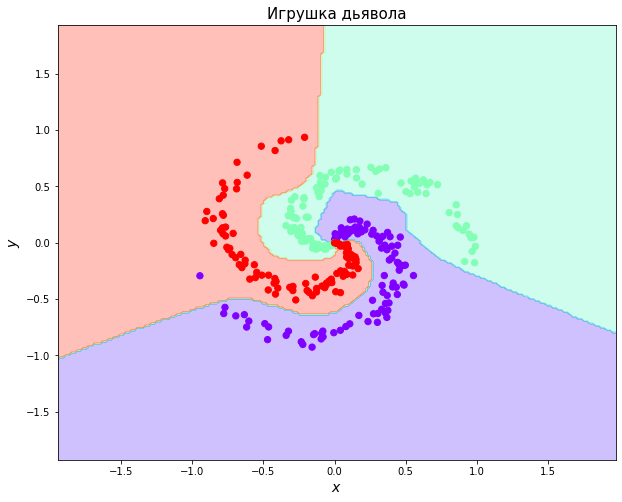

In [75]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Несколько советов о том, как строить нейросети. Код выполнен на фреймворке Keras, но, кажется, он довольно интуитивно понятен.

### Задача 2
https://pypi.org/project/python-mnist/

* __Задача:__ Распознать рукописную цифру (0-9)
* __Вход:__ картинка 28 x 28 пикселей (ч/б)

In [3]:

from keras.datasets import MNIST
data = mndata.select_emnist('digits')
print(data)

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [8]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 64, 2, 100, 10

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

NameError: name 'torch' is not defined

In [ ]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

In [1]:
import torch as t
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x
net = Net()

In [4]:
cross_el = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(net.parameters(), lr=0.001) #e-1
epoch = 10

for epoch in range(epoch):
    net.train()

    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss.backward()
        optimizer.step()

In [5]:
total = 0
correct = 0
with t.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x.view(-1, 784))
        for idx, i in enumerate(output):
            if t.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.966


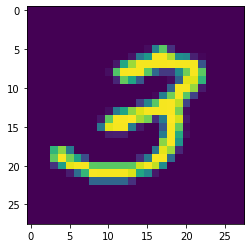

tensor(3)


In [6]:
plt.imshow(x[3].view(28, 28))
plt.show()
print(t.argmax(net(x[3].view(-1, 784))[0]))

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*

6). *Подробнее про backprop -- статья на Medium: https://medium.com/autonomous-agents/backpropagation-how-neural-networks-learn-complex-behaviors-9572ac161670*

7). *Статья из интернет по Backprop: http://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf*